# Distancias ponderadas para cada variable
# $$D(x,y) = \sqrt{(x-y)^T\cdot A\cdot(x-y)}$$

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import requests

In [3]:
session = tf.Session()

In [22]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data"
housing_header = ["CRIM", #      per capita crime rate by town
                  "ZN", #        proportion of residential land zoned for lots over 25,000 sq.ft.
                  "INDUS", #     proportion of non-retail business acres per town
                  "CHAS", #      Charles River dummy variable (= 1 if tract bounds  river; 0 otherwise)
                  "NOX", #       nitric oxides concentration (parts per 10 million)
                  "RM", #        average number of rooms per dwelling
                  "AGE",#        proportion of owner-occupied units built prior to 1940
                  "DIS", #       weighted distances to five Boston employment centres
                  "RAD", #       index of accessibility to radial highways
                  "TAX", #       full-value property-tax rate per $10,000
                  "PTRATIO",#    pupil-teacher ratio by town
                  "B", #         1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
                  "LSTAT", #     % lower status of the population
                  "MEDV" #       Median value of owner-occupied homes in $1000's
                 ]
cols_used = ["CRIM", "INDUS", "NOX", "RM", "AGE", "DIS", "TAX", "PTRATIO", "B", "LSTAT"]
num_features = len(cols_used)
housing_file = requests.get(url)
housing_data =[[float(x) for x in y.split(' ') if len(x)>=1] for y in housing_file.text.split('\n') if len(y)>=1]
y_vals = np.transpose([np.array([y[13] for y in housing_data])])
x_vals = np.array([[x for i,x in enumerate(y) if housing_header[i] in cols_used] for y in housing_data])
x_vals = (x_vals - x_vals.min(0))/x_vals.ptp(0)

In [23]:
weight_diag = x_vals.std(0)
weight_diag

array([0.09658371, 0.25123059, 0.23819571, 0.13449368, 0.28960899,
       0.19129285, 0.32131774, 0.23008566, 0.22997783, 0.19685435])

In [24]:
weight_matrix = tf.cast(tf.diag(weight_diag), dtype=tf.float32)

In [25]:
session.run(weight_matrix)

array([[0.09658372, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.2512306 , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.23819572, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.13449368, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.289609  ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.19129285, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.32131773, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.       

In [26]:
train_idx = np.random.choice(len(x_vals), round(len(x_vals)*0.8), replace=False)
test_idx = np.array(list(set(range(len(x_vals)))-set(train_idx)))

x_vals_train = x_vals[train_idx]
x_vals_test = x_vals[test_idx]

y_vals_train = y_vals[train_idx]
y_vals_test = y_vals[test_idx]

In [38]:
k = 2
batch_size = len(x_vals_test)

In [39]:
x_data_train = tf.placeholder(shape=[None, num_features], dtype=tf.float32)
x_data_test = tf.placeholder(shape=[None, num_features], dtype=tf.float32)

y_target_train = tf.placeholder(shape = [None, 1], dtype=tf.float32)
y_target_test = tf.placeholder(shape=[None, 1], dtype=tf.float32)

In [40]:
subs_terms = tf.subtract(x_data_train, tf.expand_dims(x_data_test,1))
first_prod = tf.matmul(subs_terms, tf.tile(tf.expand_dims(weight_matrix,0), [batch_size,1,1]))
second_prod = tf.matmul(first_prod, tf.transpose(subs_terms, perm=[0,2,1]))

In [41]:
distance = tf.sqrt(tf.matrix_diag_part(second_prod))

In [42]:
top_k_xvals, top_k_idx = tf.nn.top_k(tf.negative(distance), k = k)
x_sums = tf.expand_dims(tf.reduce_sum(top_k_xvals,1),1)
x_sums_rep = tf.matmul(x_sums, tf.ones([1,k], tf.float32))
x_vals_w = tf.expand_dims(tf.divide(top_k_xvals, x_sums_rep),1) # -> wi = di / \sum(dj)
top_k_yvals = tf.gather(y_target_train, top_k_idx)
prediction = tf.squeeze(tf.matmul(x_vals_w, top_k_yvals),axis=[1]) ## \sum w_i y_i

In [43]:
mse = tf.div(tf.reduce_sum(tf.square(tf.subtract(prediction, y_target_test))), batch_size)

In [44]:
num_loops = int(np.ceil(len(x_vals_test)/batch_size))

for i in range(num_loops):
    min_idx = i*batch_size
    max_idx = min((i+1)*batch_size, len(x_vals_train))
    x_batch = x_vals_test[min_idx:max_idx]
    y_batch = y_vals_test[min_idx:max_idx]
    
    predictions = session.run(prediction, feed_dict={x_data_train: x_vals_train, x_data_test: x_batch,
                                         y_target_train: y_vals_train, y_target_test: y_batch})
    batch_mse = session.run(mse, feed_dict={x_data_train: x_vals_train, x_data_test: x_batch,
                                         y_target_train: y_vals_train, y_target_test: y_batch})
    
    print("MSE = "+str(np.round(batch_mse, 3)))

MSE = 19.666


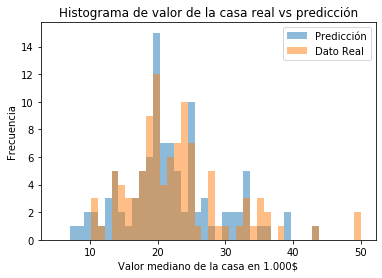

In [45]:
bins = np.linspace(5, 50, 45)
plt.hist(predictions, bins, alpha = 0.5, label = "Predicción")
plt.hist(y_batch, bins, alpha = 0.5, label = "Dato Real")
plt.title("Histograma de valor de la casa real vs predicción")
plt.xlabel("Valor mediano de la casa en 1.000$")
plt.ylabel("Frecuencia")
plt.legend(loc="upper right")
plt.show()

In [35]:
def knn(k):
    batch_size = len(x_vals_test)

    top_k_xvals, top_k_idx = tf.nn.top_k(tf.negative(distance), k = k)
    x_sums = tf.expand_dims(tf.reduce_sum(top_k_xvals,1),1)
    x_sums_rep = tf.matmul(x_sums, tf.ones([1,k], tf.float32))
    x_vals_w = tf.expand_dims(tf.divide(top_k_xvals, x_sums_rep),1) # -> wi = di / \sum(dj)
    
    top_k_yvals = tf.gather(y_target_train, top_k_idx)
    prediction = tf.squeeze(tf.matmul(x_vals_w, top_k_yvals),axis=[1]) ## \sum w_i y_i
    
    mse = tf.div(tf.reduce_sum(tf.square(tf.subtract(prediction, y_target_test))), batch_size)
    
    min_idx = i*batch_size
    max_idx = min((i+1)*batch_size, len(x_vals_train))
    x_batch = x_vals_test[min_idx:max_idx]
    y_batch = y_vals_test[min_idx:max_idx]
    
    predictions = session.run(prediction, feed_dict={x_data_train: x_vals_train, x_data_test: x_batch,
                                         y_target_train: y_vals_train, y_target_test: y_batch})
    batch_mse = session.run(mse, feed_dict={x_data_train: x_vals_train, x_data_test: x_batch,
                                         y_target_train: y_vals_train, y_target_test: y_batch})
    
    return batch_mse

In [36]:
mse_k = []
for k in range(2,30):
    mse_t = knn(k)
    mse_k.append(mse_t)
    print(str(k)+", MSE="+str(mse_t))

2, MSE=19.666325
3, MSE=20.289074
4, MSE=20.729017
5, MSE=20.361536
6, MSE=21.871042
7, MSE=20.80564
8, MSE=23.084864
9, MSE=25.052065
10, MSE=26.588263
11, MSE=27.153997
12, MSE=28.488678
13, MSE=27.6612
14, MSE=28.009789
15, MSE=28.035538
16, MSE=28.030197
17, MSE=28.287724
18, MSE=28.62185
19, MSE=29.491585
20, MSE=30.184687
21, MSE=31.32505
22, MSE=31.591114
23, MSE=31.546776
24, MSE=31.524197
25, MSE=31.463211
26, MSE=32.119392
27, MSE=32.4085
28, MSE=33.076256
29, MSE=33.23792


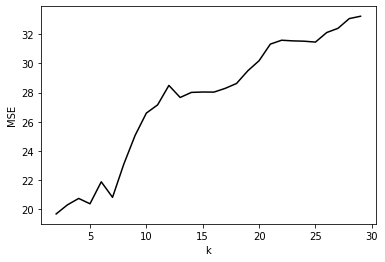

In [37]:
plt.plot(range(2,30), mse_k, 'k-', label="MSE")
plt.xlabel("k")
plt.ylabel("MSE")
plt.show()